In [1]:
# analyze residues orientation
# from gromacs.fileformats.xvg import XVG
import numpy as np
from matplotlib import pyplot as plt
import os
# from tqdm import tqdm
import MDAnalysis as mda
from MDAnalysis.analysis import align

import pickle
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "TeX Gyre Heros"




/home/xlf/Apps/anaconda3/envs/xlf/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
# smooth data
# input: data, box_pts
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    for i in range(box_pts):
        y_smooth[i] = y[:(2*i+1)].mean()
    for i in range(len(y)-box_pts,len(y)):
        y_smooth[i] = y[-(len(y)-i)*2:].mean()
    return y_smooth
def plotFormat():
    ax = plt.gca()
    width = 3
    ax.spines["top"].set_linewidth(width)
    ax.spines["right"].set_linewidth(width)
    ax.spines["bottom"].set_linewidth(width)
    ax.spines["left"].set_linewidth(width)
    plt.tick_params(width=3,length = 10)
def dealPeriodicAngle(arr,period):
    newArr = arr.copy()
    diff = np.diff(arr)
    for i in range(len(arr)-1):
        if diff[i]>period/2:
            newArr[i+1:] -= period
        elif diff[i]<-period/2:
            newArr[i+1:] += period
    return newArr
# get the longest continuous part
def getLongestContPart(arr,cutoff):
    diff = np.diff(arr)
    diff_bina = np.array(abs(diff)<cutoff,int)
    diff_bina
    diff_bina

    # get all the continuous part
    contiPartList = []
    contiPart = []
    inds = np.where(diff_bina==1)[0]
    for i in range(len(inds)):
        if len(contiPart)==0:
            ind = inds[i]
            contiPart.append(ind)
        else:
            if inds[i]-ind ==1:
                contiPart.append(inds[i])
                ind = inds[i]
            else:
                contiPartList.append(contiPart)
                contiPart = []
                ind = inds[i]
                contiPart.append(ind)
        if i==len(inds)-1:
            contiPartList.append(contiPart)

    # extend the continuous list
    contiPartListExt = []
    for i in range(len(contiPartList)):
        li = contiPartList[i]
        li.append(li[-1]+1)
        contiPartListExt.append(li)
    contiPartListExt

    # get the longest array
    arrLen = np.array([len(x) for x in contiPartListExt])
    ind = np.argmax(arrLen)
    indices = contiPartListExt[ind]
    return indices

In [4]:

fileNames = ["pull_combine1and2","pull_rep2_combine1and2","pull_rep3_combine1and2"]
for fileName in fileNames:
    top_dire = './'+fileName+'_prot.tpr'
    trj_dire = './'+fileName+'_prot_fit_extractFrames.xtc'
    
    trj_dires = trj_dire
    u = mda.Universe(top_dire,trj_dire)


    u.transfer_to_memory(verbose=True) 

    Nt = len(u.trajectory)  # number of frames
    t_total = u.trajectory[-1].time/1000.0 # unit: ns
    t_frame = u.trajectory[1].time/1000.0 
    t_plot = np.arange(Nt)*t_frame
    print('t_frame = '+str(t_frame)+' ns, t_total = '+str(t_total)+' ns')
    
    # align structure
    refGroFile = "./step6.6_equilibration_nojump.gro"
    ref = mda.Universe(refGroFile)   # reference structure 
    alignment = align.AlignTraj(u, ref, select="resindex 0 to 132 and name CA", filename=fileName+'_align.xtc')
    alignment.run()

    # select Tim17, resid 6-138, conserved resdiues: 65F 68W 72F; 24M
    tim17RefResIds = [24,65,68,72,121]
    tim17 = u.residues[0:133].atoms
    tim17ResIds = tim17.residues.resindices - tim17.residues.resindices[0] + 6

    ind = np.where(tim17ResIds==68)[0]
    tim17.residues[ind].resnames

    # select Mgr2, resid 11-77, conserved residues: 67F, 70F; 33T
    mgr2RefResIds = [33,67,70]
    mgr2 = u.residues[216:283].atoms
    mgr2ResIds = mgr2.residues.resindices - mgr2.residues.resindices[0] + 11

    # show sequence of substrate, resid 131-148
    subst = u.residues[283:301].atoms
    substResIds = subst.residues.resindices - subst.residues.resindices[0] + 131

    # calculate 65F position
    ind = np.where(tim17ResIds==65)[0]
    u.trajectory[0]
    zRefPos = tim17.residues[ind].atoms.select_atoms("name CA").positions[0,2]
    xyRefPos = tim17.residues[ind].atoms.select_atoms("name CA").positions[0,0:2]
    substXYMeanPos = subst.select_atoms("name CA").positions.mean(axis = 0)[0:2]
    diff = xyRefPos-substXYMeanPos
    thetaRef = np.arctan2(diff[1],diff[0])
    print("Tim17 65F z-pos = {:.2f} A, theta = {:.2f} deg".format(zRefPos,thetaRef*180/np.pi))

    resOrienDict = {"LYS":["CA","NZ"],"ASP":["CA","CG"],"GLU":["CA","CD"],"PHE":["CA","CZ"],"ASN":["CA","CG"],
                    "ALA":["CA","CB"],"GLY":["CA","CA"],"VAL":["CA","CG1"],"THR":["CA","CG2"],"ILE":["CA","CD"],
                    "PRO":["CA","CG"],"LEU":["CA","CD1"],"HSD":["CA","CE1"]}
    # show K orientation
    # selResInds = [0,5,6,12,1,11,2,3,9,16,4,7,8,10,13,17,14,15]
    selResInds = np.arange(18)
    selResNames = [subst.residues.resnames[i]+str(substResIds[i]) for i in selResInds]
    dataRecordList = []
    for selResInd in selResInds:
        ag = subst.residues[selResInd].atoms
        pos = u.trajectory.timeseries(asel=ag)
        resType = ag.residues.resnames[0]
        ind1 = np.where(ag.names==resOrienDict[resType][0])[0][0]
        ind2 = np.where(ag.names==resOrienDict[resType][1])[0][0]
        ind1,ind2
        orienArr = pos[ind2,:,:2] - substXYMeanPos
        posArr = pos[ind1,:,:]
        # x-y plane
        thetaArr = np.arctan2(orienArr[:,1],orienArr[:,0]) - thetaRef
        zArr = posArr[:,2] - zRefPos
        dataRecordList.append((zArr,thetaArr))
    
    # show residues orientation: Tim17, Mgr2
    resIndList = np.array(tim17RefResIds)-6
    resIndList = np.append(resIndList,np.array(mgr2RefResIds)-11+216)
    timResThetaList = []
    for resInd in resIndList:
        ag = u.residues[resInd].atoms.select_atoms("not backbone and not name H*")
        pos = u.trajectory.timeseries(asel=ag)
        orienArr = pos[:,:,:2] - substXYMeanPos
        thetaArr = np.arctan2(orienArr[:,:,1],orienArr[:,:,0]) - thetaRef
        thetaArr = thetaArr%(2*np.pi)
        timResThetaList.append([(thetaArr[:,i].min(),thetaArr[:,i].max()) for i in range(thetaArr.shape[1])])

    # save data
    data = dict(data = dataRecordList,timResThetaList=timResThetaList)
    with open(fileName+'_orien_test.pkl', 'wb') as f:
        pickle.dump(data, f)


Loading frames:   0%|          | 0/834 [00:00<?, ?it/s]

t_frame = 1.0 ns, t_total = 833.0 ns
Tim17 65F z-pos = 46.32 A, theta = -120.47 deg


Loading frames:   0%|          | 0/844 [00:00<?, ?it/s]

t_frame = 1.0 ns, t_total = 843.0 ns
Tim17 65F z-pos = 46.32 A, theta = -120.47 deg


Loading frames:   0%|          | 0/861 [00:00<?, ?it/s]

t_frame = 1.0 ns, t_total = 860.0 ns
Tim17 65F z-pos = 46.32 A, theta = -120.47 deg


In [6]:

# read pkl results
dataList = []
for fileName in fileNames:
    with open(fileName+'_orien_test.pkl', 'rb') as f:
        data = pickle.load(f)
    dataList.append(data)

/tmp/ipykernel_942767/2480241727.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1,projection="polar")
/tmp/ipykernel_942767/2480241727.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,1,1,projection="polar")


(0.0, 100.0)

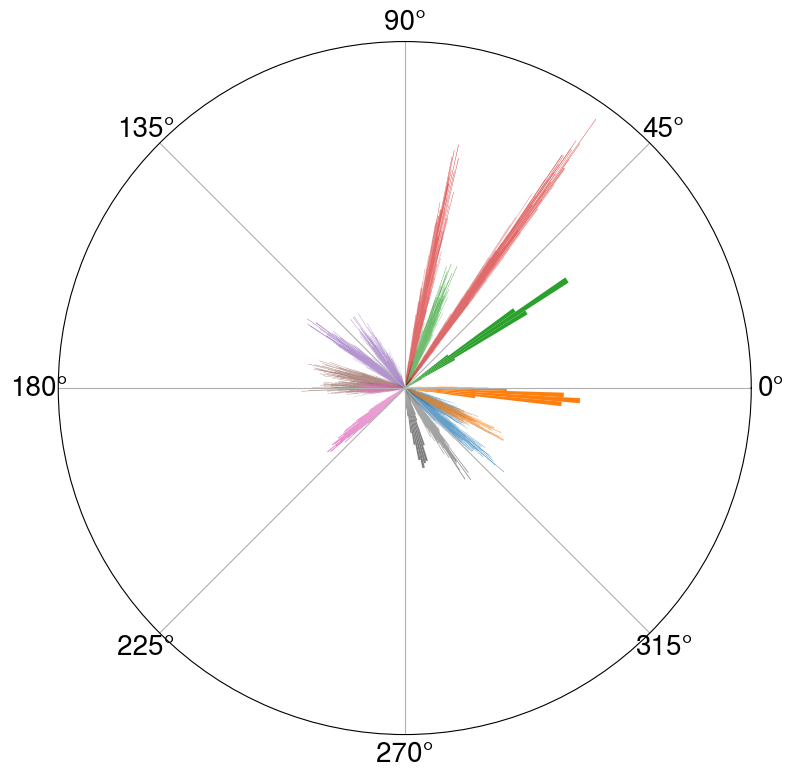

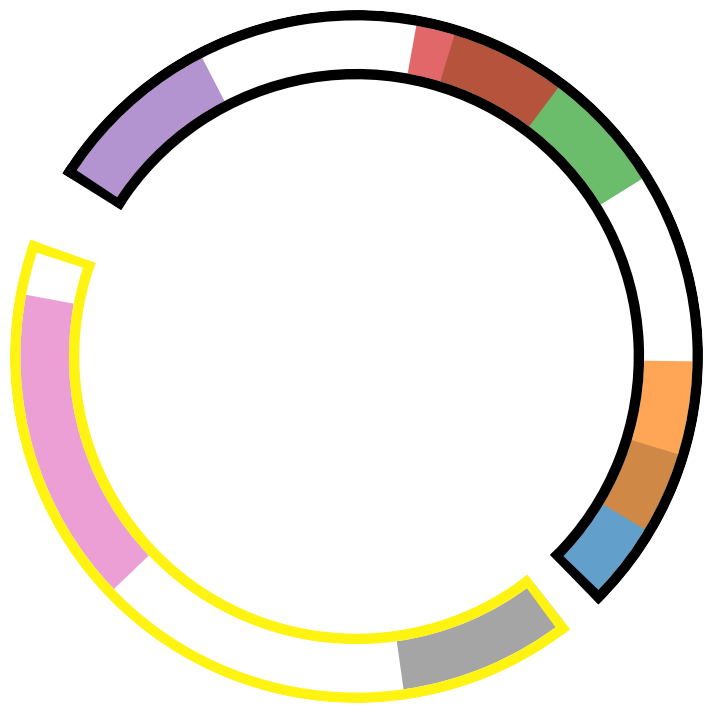

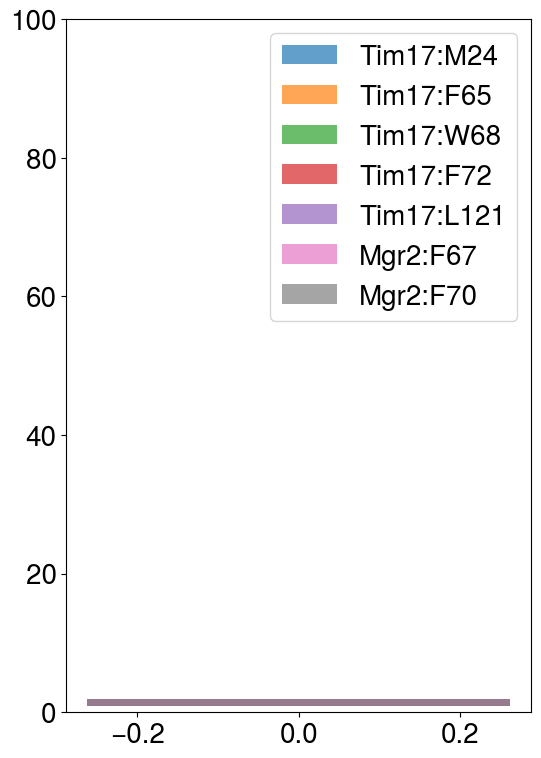

In [7]:
# show tim residues angle distribution
timResThetaList = np.concatenate((np.array(dataList[0]["timResThetaList"]),np.array(dataList[1]["timResThetaList"])),axis = 1)
timResThetaList.shape

# show angle distribution in f

res_i = 0
plt.subplots(1,1, figsize=(9,9))
ax = plt.subplot(1,1,1,projection="polar")
histx= []
histy= []
for res_i in range(timResThetaList.shape[0]):
    b = timResThetaList[res_i,:,0]
    a = ax.hist((b-np.pi*0.1)%(2*np.pi)+np.pi*0.1,bins = 200, density= True,color="C"+str(res_i))
    histx.append((a[1][1:]+a[1][:-1])/2)
    histy.append(a[0])
    b = timResThetaList[res_i,:,1]
    a = ax.hist((b-np.pi*0.1)%(2*np.pi)+np.pi*0.1,bins = 200, density= True,color="C"+str(res_i))
    histx.append((a[1][1:]+a[1][:-1])/2)
    histy.append(a[0])
    ax.set_yticks([])

plt.subplots(1,1, figsize=(9,9))
ax = plt.subplot(1,1,1,projection="polar")
legends = ["Tim17:M24","Tim17:F65","Tim17:W68","Tim17:F72","Tim17:L121","Mgr2:T33","Mgr2:F67","Mgr2:F70"]

refSectorArr = np.zeros((timResThetaList.shape[0],2))   # center,width

for res_i in range(timResThetaList.shape[0]):
    for i in range(res_i*2,res_i*2+1):
        ind1=np.argmax(histy[i])
        ind1_half = np.argmin(abs(histy[i]-histy[i][ind1]/2))
        width1 = abs(histx[i][ind1]-histx[i][ind1_half])
        ind2=np.argmax(histy[i+1])
        ind2_half = np.argmin(abs(histy[i+1]-histy[i+1][ind2]/2))
        width2 = abs(histx[i+1][ind2]-histx[i+1][ind2_half])
        
        ind1_moreHalf = np.where(histy[i]>histy[i][ind1]/2)[0]
        ind2_moreHalf = np.where(histy[i+1]>histy[i+1][ind2]/2)[0]
        ind1_half = ind1_moreHalf[0]
        ind2_half = ind2_moreHalf[-1]
        
        # ax.plot([histx[i][ind1],histx[i+1][ind2]],[1,1],color = "C"+str(res_i),linewidth=4)
        # show shade
        #plt.fill_betweenx(np.linspace(0,1,100),histx[i][ind1],histx[i+1][ind2],color = "C"+str(res_i),alpha=0.5)
        center = (histx[i][ind1]+histx[i+1][ind2])/2
        width = abs(histx[i][ind1]-histx[i+1][ind2])
        
        center = (histx[i][ind1_half]+histx[i+1][ind2_half])/2
        width = abs(histx[i][ind1_half]-histx[i+1][ind2_half])
        # plt.bar(center,1,color= "C"+str(res_i),alpha=0.5,width=width)
        refSectorArr[res_i,:] = np.array([center,width])

def plotSector():
    for res_i in range(timResThetaList.shape[0]):
        if res_i !=5:
            center,width = refSectorArr[res_i,:]
            plt.bar(center,0.14,bottom=0.83,color= "C"+str(res_i),alpha=0.7,width=width)

    # boundary for Tim17 and Mgr2
    res_i = 0
    c1,w1 = refSectorArr[res_i,:]
    res_i = 4
    c2,w2 = refSectorArr[res_i,:]
    ang_min = c1-w1/2 - np.pi*2
    ang_max = c2+w2/2
    c,w = (ang_min+ang_max)/2, ang_max-ang_min
    plt.bar(c,0.03,bottom=0.8,color= "k",alpha=1,width=w)
    plt.bar(c,0.03,bottom=0.97,color= "k",alpha=1,width=w)
    plt.bar(ang_min+0.015,0.2,bottom=0.8,color= "k",alpha=1,width=0.03)
    plt.bar(ang_max-0.015,0.2,bottom=0.8,color= "k",alpha=1,width=0.03)

    res_i = 5
    c1,w1 = refSectorArr[res_i,:]
    res_i = 7
    c2,w2 = refSectorArr[res_i,:]
    ang_min = c1-w1/2
    ang_max = c2+w2/2
    c,w = (ang_min+ang_max)/2, ang_max-ang_min
    
    plt.bar(c,0.03,bottom=0.8,color= "#FFF311",alpha=1,width=w)
    plt.bar(c,0.03,bottom=0.97,color= "#FFF311",alpha=1,width=w)
    plt.bar(ang_min+0.015,0.2,bottom=0.8,color= "#FFF311",alpha=1,width=0.03)
    plt.bar(ang_max-0.015,0.2,bottom=0.8,color= "#FFF311",alpha=1,width=0.03)

plotSector()
ax.set_yticks([])
plt.ylim(0,1)
# plt.axes().get_xaxis().set_visible(False)
plt.axis("off")
# plt.xticks(np.arange(0,360,45))
# plt.grid()

"""
# histogram
ax = plt.subplot(1,1,1,projection="polar")
i=0
for res_i in range(timResThetaList.shape[0]):
    for i in range(res_i*2,(res_i+1)*2):
        ax.plot(histx[i],histy[i]/histy[i].max(),color = "C"+str(res_i))
ax.set_yticks([])
"""
plt.subplots(1,1, figsize=(6,9))
for i in range(len(legends)):
    if i!=5:
        plt.bar(0,1,bottom=0.9,color= "C"+str(i),alpha=0.7,width=width,label=legends[i])
plt.legend()
plt.ylim(0,100)


/tmp/ipykernel_942767/3536867812.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nRes,5,i+1+i_Res*5,projection="polar")


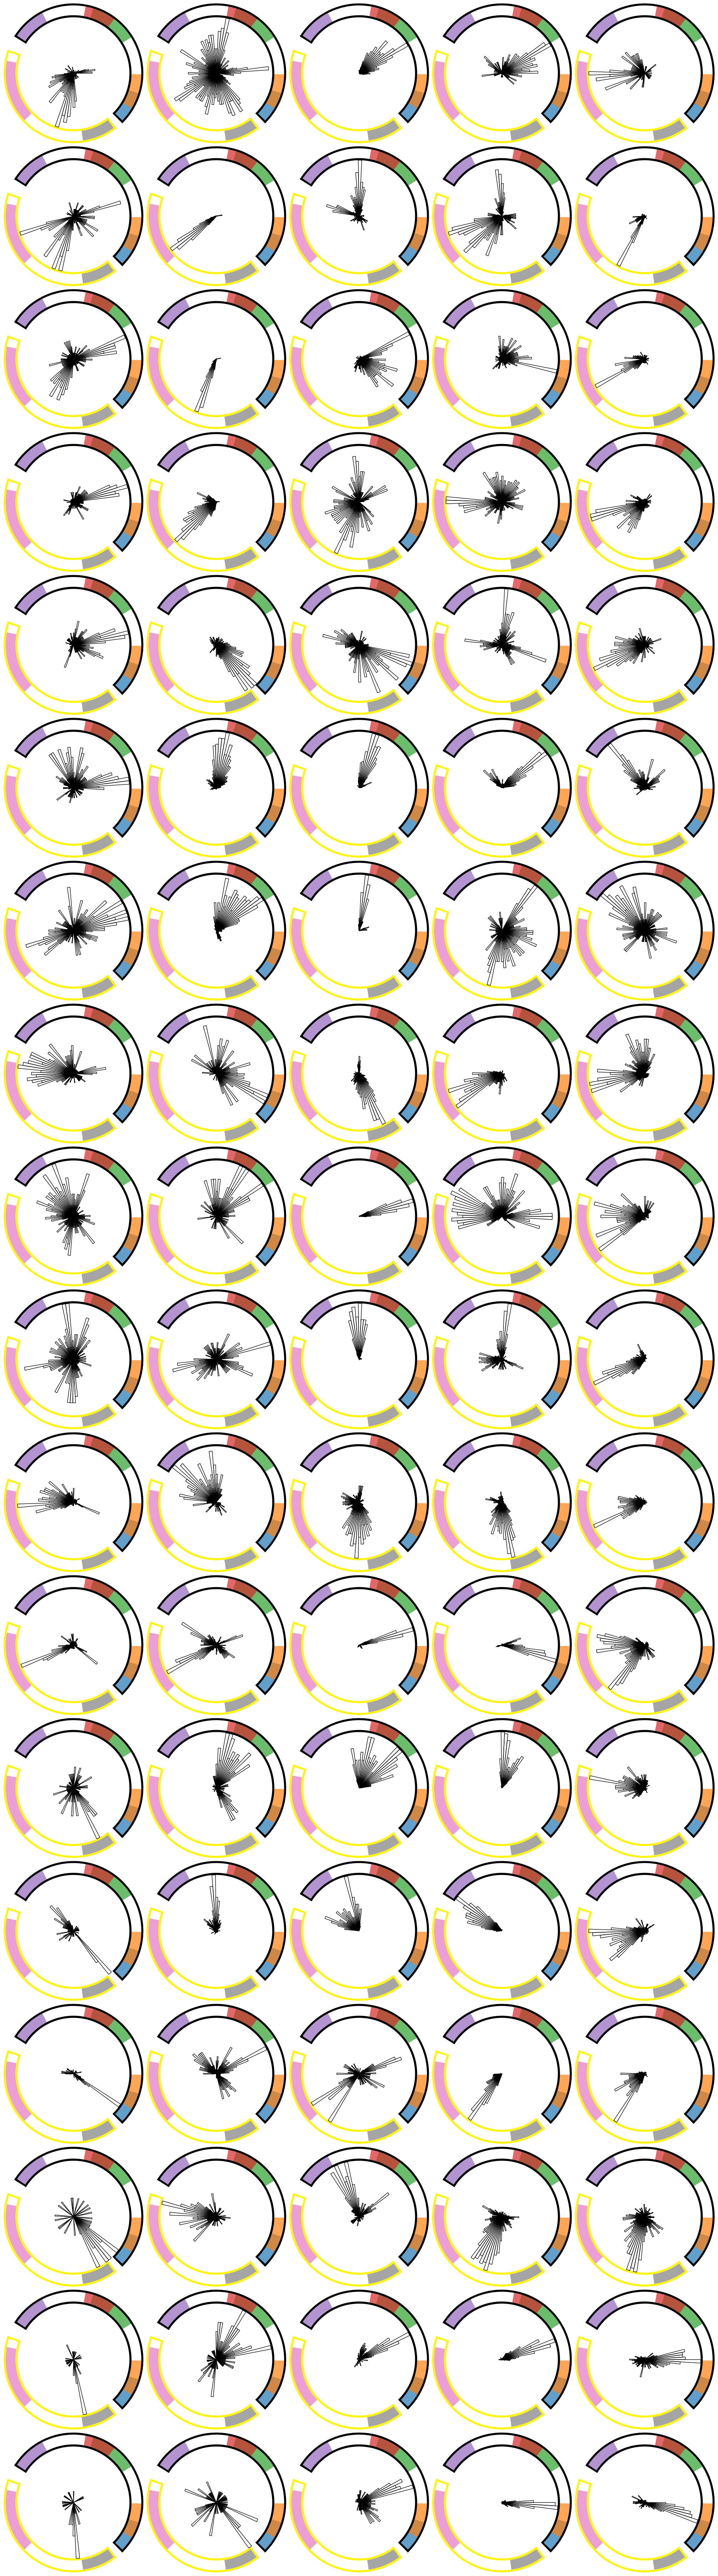

In [8]:
zArrList = []
thetaArrList = []
for resInd in range(len(dataList[1]["data"])):
    # combine two sets of data
    zArrCombine = np.concatenate((dataList[0]["data"][resInd][0],dataList[1]["data"][resInd][0],dataList[2]["data"][resInd][0]))
    thetaArrCombine = np.concatenate((dataList[0]["data"][resInd][1],dataList[1]["data"][resInd][1],dataList[2]["data"][resInd][1]))
    
    zArr = zArrCombine
    thetaArr = thetaArrCombine

    zArrList.append(zArr)
    thetaArrList.append(thetaArr)
    
# prepare z slices
zRange_mins = np.arange(-25,16,10)
zRange_maxs = zRange_mins+10

# selResInds = [0,5,6,12,1,11]
selResNames = [subst.residues.resnames[i]+str(substResIds[i]) for i in selResInds]
nRes = len(selResNames)
fig, axes = plt.subplots(nRes,5, figsize=(20,4*nRes),layout="constrained")
for i_Res,zArr,thetaArr in zip(np.arange(nRes),zArrList,thetaArrList):
    for i in range(len(zRange_mins)):
        zMin = zRange_mins[i]
        zMax = zRange_maxs[i]
        inds = np.where((zArr>=zMin)&(zArr<zMax))[0]
        ax = plt.subplot(nRes,5,i+1+i_Res*5,projection="polar")
        
        plotSector()        
        plt.axis("off")
        # normalize the max value = 1
        hist,bin_edges = np.histogram(thetaArr[inds]%(2*np.pi),bins = np.linspace(0,2*np.pi,100))
        bin_mids = (bin_edges[:-1]+bin_edges[1:])/2
        a = ax.bar(bin_mids,hist/max(hist)*0.8,width =bin_mids[1]-bin_mids[0],facecolor="none",edgecolor="k")
        plt.ylim(0,1)
        
        ax.set_yticks([])
        ax.set_xticklabels([])
        if i>0:
            ax.set_xticklabels([])

# save as pdf

